## Importing Libraries

In [19]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from datetime import datetime
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Layer, Input, GRU, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import shap

In [20]:
# Hide warnings!
import warnings
warnings.filterwarnings("ignore")

In [21]:
# For reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Forecasting PM10 based on PM2.5 pre-trained model

In [22]:
# Importing dataset from station Aotizhongxin
df = pd.read_csv("datasets/cleaned_df.csv")

In [23]:
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,6,1.2


In [24]:
# Defining features and target
features_PM10 = df.drop(columns = ['NO2','SO2','PM2.5','CO','O3'])

In [25]:
features_PM10

,PM10,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...
35059,29.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,37.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,37.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,44.0,10.5,1014.4,-12.9,0.0,6,1.2


In [26]:
features_PM10.isna().sum()

PM10    0
TEMP    0
PRES    0
DEWP    0
RAIN    0
wd      0
WSPM    0
dtype: int64

In [27]:
# Changing the position of the 'wd' column

# Column to move
col_to_move = 'wd'

# Get a list of all columns
cols = list(features_PM10.columns)

# Remove the column from the list
cols.remove(col_to_move)

# Append the column to the end of the list
cols.append(col_to_move)

# Reindex the DataFrame
features_PM10 = features_PM10[cols]

In [28]:
features_PM10

,PM10,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,4.0,-0.7,1023.0,-18.8,0.0,4.4,6
1,8.0,-1.1,1023.2,-18.2,0.0,4.7,3
2,7.0,-1.1,1023.5,-18.2,0.0,5.6,6
3,6.0,-1.4,1024.5,-19.4,0.0,3.1,7
4,3.0,-2.0,1025.2,-19.5,0.0,2.0,3
...,...,...,...,...,...,...,...
35059,29.0,12.5,1013.5,-16.2,0.0,2.4,7
35060,37.0,11.6,1013.6,-15.1,0.0,0.9,14
35061,37.0,10.8,1014.2,-13.3,0.0,1.1,7
35062,44.0,10.5,1014.4,-12.9,0.0,1.2,6


In [29]:
# Create sequences
SEQ_LENGTH = 1
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [30]:
fine_tuning_size = [0.1, 0.2, 0.3, 0.4, 0.5]

In [31]:
best_params_ann = {'num_hidden_layers': 1, 'num_units': 8, 'dropout_rate': 0.14382634727054072, 
                  'learning_rate': 0.001540087615233534, 'regularization': None, 
                  'regularization_strength': 0}

In [32]:
def train_test_split_standardize(train_size):
    
    len_train = int(train_size * len(features_PM10))
    
    train_df = features_PM10.iloc[:len_train, :-1]
    test_df = features_PM10.iloc[len_train:, :-1]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    train_df['wd'] = features_PM10.iloc[:len_train, -1]
    test_df['wd'] = features_PM10.iloc[len_train:, -1]
    
    X_train, y_train = create_sequences(np.array(train_df), SEQ_LENGTH)
    X_test, y_test = create_sequences(np.array(test_df), SEQ_LENGTH)
    
    return X_train, y_train, X_test, y_test

In [33]:
X_train_PM10, y_train_PM10, X_test_PM10, y_test_PM10 = train_test_split_standardize(0.3)

In [34]:
print("Train shape: ", X_train_PM10.shape)
print("Test shape: ", X_test_PM10.shape)

Train shape:  (10518, 1, 7)
Test shape:  (24544, 1, 7)


In [35]:
X_train_PM10

array([[[-1.26965834e+00, -1.30927509e+00,  1.30236737e+00, ...,
         -6.20225909e-02,  2.44235361e+00,  6.00000000e+00]],

       [[-1.22678319e+00, -1.34717207e+00,  1.32307167e+00, ...,
         -6.20225909e-02,  2.70391712e+00,  3.00000000e+00]],

       [[-1.23750198e+00, -1.34717207e+00,  1.35412812e+00, ...,
         -6.20225909e-02,  3.48860768e+00,  6.00000000e+00]],

       ...,

       [[-2.19217017e-01, -1.13035246e-02, -1.61693932e+00, ...,
         -6.20225909e-02, -8.70784300e-01,  1.00000000e+00]],

       [[-1.01310338e-01,  1.71192105e-02, -1.59623501e+00, ...,
         -6.20225909e-02, -7.83596461e-01,  1.00000000e+00]],

       [[ 1.23784232e-01,  1.21335906e-01, -1.52376996e+00, ...,
         -6.20225909e-02,  1.09409591e-03,  4.00000000e+00]]])

In [71]:
mse_scores = []
mae_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

for s in fine_tuning_size:
    
    # Training set
    
    X_train_PM10, y_train_PM10, X_test_PM10, y_test_PM10 = train_test_split_standardize(s)
        
    # Loading the saved model
    pre_trained_model = tf.keras.models.load_model('pre_trained_models/LSTM_model.h5')
    pre_trained_model.compile(optimizer=Adam(learning_rate = best_params_ann['learning_rate']/10), loss='mse', metrics=['mae'])
    pre_trained_model.fit(X_train_PM10, y_train_PM10, epochs = 50, batch_size=32, shuffle=False)
    
    # Make predictions on the test data
    y_pred_ft = pre_trained_model.predict(X_test_PM10)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_PM10, y_pred_ft)
    mae = mean_absolute_error(y_test_PM10, y_pred_ft)
    r2 = r2_score(y_test_PM10, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_PM10, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_PM10, y_pred_ft))
    
    # Append to list scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    

Epoch 1/50
110/110 [==============================] - 2s 2ms/step - loss: 0.2587 - mae: 0.3094
Epoch 2/50
110/110 [==============================] - 0s 1ms/step - loss: 0.2460 - mae: 0.3029
Epoch 3/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2552 - mae: 0.3054
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2486 - mae: 0.3025
Epoch 5/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2452 - mae: 0.3048
Epoch 6/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2464 - mae: 0.3078
Epoch 7/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2473 - mae: 0.3056
Epoch 8/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2569 - mae: 0.3058
Epoch 9/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2439 - mae: 0.3040
Epoch 10/50
110/110 [==============================] - 0s 2ms/step - loss: 0.2459 - mae: 0.3085
Epoch 11/50
110/110 [============================

220/220 [==============================] - 0s 1ms/step - loss: 0.2073 - mae: 0.2935
Epoch 36/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2118 - mae: 0.2943
Epoch 37/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2100 - mae: 0.2931
Epoch 38/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2058 - mae: 0.2903
Epoch 39/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2042 - mae: 0.2896
Epoch 40/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2097 - mae: 0.2924
Epoch 41/50
220/220 [==============================] - 0s 2ms/step - loss: 0.2043 - mae: 0.2915
Epoch 42/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2075 - mae: 0.2904
Epoch 43/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2063 - mae: 0.2911
Epoch 44/50
220/220 [==============================] - 0s 1ms/step - loss: 0.2068 - mae: 0.2927
Epoch 45/50
220/220 [==============================]

439/439 [==============================] - 1s 2ms/step - loss: 0.1975 - mae: 0.2723
Epoch 20/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1974 - mae: 0.2716
Epoch 21/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1977 - mae: 0.2713
Epoch 22/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1991 - mae: 0.2712
Epoch 23/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1944 - mae: 0.2706
Epoch 24/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1968 - mae: 0.2717
Epoch 25/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1971 - mae: 0.2717
Epoch 26/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1974 - mae: 0.2722
Epoch 27/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1996 - mae: 0.2718
Epoch 28/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1919 - mae: 0.2698
Epoch 29/50
439/439 [==============================]

In [77]:
mae_scores

[0.23938966589703772,
 0.23963450226772598,
 0.21296116477608973,
 0.21163839092025877,
 0.1969668015058229]

In [78]:
mse_scores

[0.15529980057883283,
 0.1698346495428649,
 0.12617249024540975,
 0.13660985749187812,
 0.11531081633382574]

In [79]:
rmse_scores

[0.3940809568842839,
 0.41210999689750905,
 0.35520767199683306,
 0.369607707565573,
 0.33957446360677024]

In [80]:
mape_scores 

[0.8204466045349189,
 0.9092402237349083,
 0.7484483786171781,
 0.9009974057458355,
 1.1081443114067566]

In [81]:
r2_scores

[0.876705388460033,
 0.8783189509068716,
 0.8803838504530199,
 0.8898245942329162,
 0.8872961705000101]

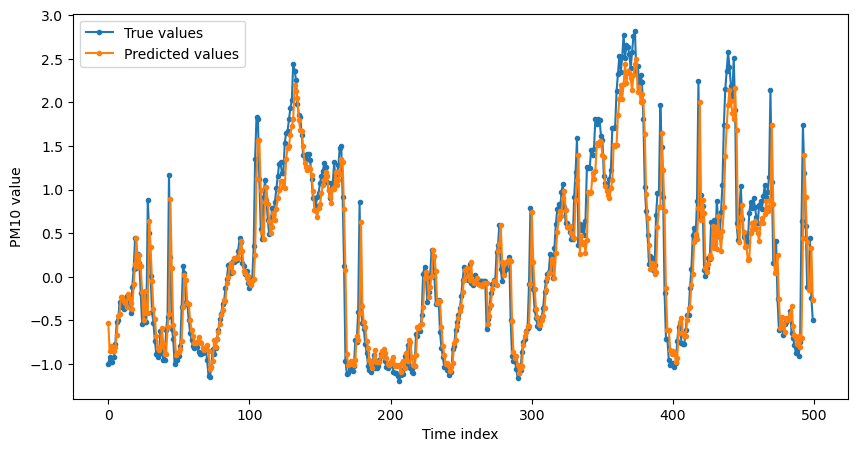

In [42]:
# Forecasting test set values

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(np.array(y_test_PM10)[:500], marker = '.', label = 'True values')
plt.plot(y_pred_ft[:500], marker = '.', label = 'Predicted values')

plt.legend()

plt.xlabel("Time index")
plt.ylabel("PM10 value")

#plt.savefig("actual_vs_forecasts_plot_PM10.pdf")
plt.show()

## Forecasting PM10 without Transfer Learning

In [43]:
def build_ann_model(input_shape):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(8, activation='relu'))
              
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [44]:
mse_scores_2 = []
mae_scores_2 = []
rmse_scores_2 = []
mape_scores_2 = []
r2_scores_2 = []

for s in fine_tuning_size:
    # Training set
    X_train_PM10, y_train_PM10, X_test_PM10, y_test_PM10 = train_test_split_standardize(s)
    
    # Loading the saved model
    model = build_ann_model(X_train_PM10.shape[1:])
    model.fit(X_train_PM10, y_train_PM10, epochs = 50, shuffle = False, batch_size = 32)
    
    # Make predictions on the test data
    y_pred_ft = model.predict(X_test_PM10)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_PM10, y_pred_ft)
    mae = mean_absolute_error(y_test_PM10, y_pred_ft)
    r2 = r2_score(y_test_PM10, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_PM10, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_PM10, y_pred_ft))
    
    # Append to list scores
    mse_scores_2.append(mse)
    mae_scores_2.append(mae)
    r2_scores_2.append(r2)
    rmse_scores_2.append(rmse)
    mape_scores_2.append(mape)
    
    

Epoch 1/50
110/110 [==============================] - 1s 2ms/step - loss: 8.0498 - mae: 2.1412
Epoch 2/50
110/110 [==============================] - 0s 1ms/step - loss: 2.7168 - mae: 1.2043
Epoch 3/50
110/110 [==============================] - 0s 1ms/step - loss: 2.0742 - mae: 1.0662
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 1.6972 - mae: 0.9804
Epoch 5/50
110/110 [==============================] - 0s 2ms/step - loss: 1.4767 - mae: 0.9187
Epoch 6/50
110/110 [==============================] - 0s 2ms/step - loss: 1.2673 - mae: 0.8534
Epoch 7/50
110/110 [==============================] - 0s 1ms/step - loss: 1.1567 - mae: 0.8205
Epoch 8/50
110/110 [==============================] - 0s 2ms/step - loss: 1.0867 - mae: 0.7972
Epoch 9/50
110/110 [==============================] - 0s 3ms/step - loss: 0.9656 - mae: 0.7544
Epoch 10/50
110/110 [==============================] - 0s 3ms/step - loss: 0.9029 - mae: 0.7247
Epoch 11/50
110/110 [============================

Epoch 36/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2167 - mae: 0.3025
Epoch 37/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2145 - mae: 0.3016
Epoch 38/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2145 - mae: 0.2992
Epoch 39/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2076 - mae: 0.2970
Epoch 40/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2123 - mae: 0.2977
Epoch 41/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2072 - mae: 0.2984
Epoch 42/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2111 - mae: 0.2965
Epoch 43/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2239 - mae: 0.3024
Epoch 44/50
220/220 [==============================] - 1s 3ms/step - loss: 0.2090 - mae: 0.2956
Epoch 45/50
220/220 [==============================] - 0s 2ms/step - loss: 0.2132 - mae: 0.2973
Epoch 46/50
220/220 [===================

439/439 [==============================] - 1s 2ms/step - loss: 0.2147 - mae: 0.2851
Epoch 21/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2099 - mae: 0.2841
Epoch 22/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2100 - mae: 0.2823
Epoch 23/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2042 - mae: 0.2813
Epoch 24/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2076 - mae: 0.2853
Epoch 25/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2112 - mae: 0.2832
Epoch 26/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2062 - mae: 0.2832
Epoch 27/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2106 - mae: 0.2835
Epoch 28/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2029 - mae: 0.2812
Epoch 29/50
439/439 [==============================] - 1s 2ms/step - loss: 0.2031 - mae: 0.2825
Epoch 30/50
439/439 [==============================]

In [45]:
mae_scores_2

[0.32989695191976415,
 0.2680844767503111,
 0.2369768952378369,
 0.24330260004953713,
 0.21817822409218027]

In [46]:
mse_scores_2

[0.23301209160729994,
 0.18555162440321354,
 0.13776594596346603,
 0.16044002983570246,
 0.12465394318444507]

In [47]:
rmse_scores_2

[0.4827132602356185,
 0.4307570363943154,
 0.3711683525887761,
 0.40054965963748174,
 0.3530636531624929]

In [48]:
r2_scores_2

[0.8150085498387111,
 0.8670582453045389,
 0.869392829111997,
 0.8706056377411675,
 0.8781642762940015]